# R: Explore Sales Data from Enterprise Systems through Machine Learning

## R implementation for association rules mining (arules package)

Initializing libraries

In [2]:
library(arules)
library(plyr)

Loading the data from the object storage

In [4]:
#An example of using DSX code insertion features
getObjectStorageFileWithCredentials <- function(container, filename) {
    # This functions returns a textConnection object for a file
    # from Bluemix Object Storage V3.

    if(!require(httr)) install.packages('httr')
    if(!require(RCurl)) install.packages('RCurl')
    library(httr, RCurl)
    auth_url <- paste("https://identity.open.softlayer.com",'/v3/auth/tokens', sep= '')
    auth_args <- paste('{"auth": {"identity": {"password": {"user": {"domain": {"id": ', "9a7ae1a3e8b84f6ea4f35b56b3ae406e",'},"password": ',
                    "H5&9j(pxOV.r^7*K",',"name": ', "admin_026e9a06f554f61b684fe44eb0a70f6960361605",'}},"methods": ["password"]}}}', sep='"')
    auth_response <- httr::POST(url = auth_url, body = auth_args)
    x_subject_token <-  headers(auth_response)[['x-subject-token']]
    auth_body <-  content(auth_response)
    access_url <-  unlist(lapply(auth_body[['token']][['catalog']], function(catalog){
        if((catalog[['type']] == 'object-store')){
            lapply(catalog[['endpoints']], function(endpoints){
                if(endpoints[['interface']] == 'public' && endpoints[['region_id']] == 'dallas') {
                    paste(endpoints[['url']], container, filename, sep='/')}
            })
        }
    }))
    data <- content(httr::GET(url = access_url, add_headers ("Content-Type" = "application/json", "X-Auth-Token" = x_subject_token)), as="text")
    textConnection(data)
}

df <-  read.csv(file = getObjectStorageFileWithCredentials("notebooks", "transactions.csv"))
print('A sample of loaded data')
head(df)

No encoding supplied: defaulting to UTF-8.


[1] "A sample of loaded data"


PRODUCT_LINE,PRODUCT_TYPE,CUST_ORDER_NUMBER,CITY,STATE,COUNTRY,GENDER,AGE,MARITAL_STATUS,PROFESSION
Personal Accessories,Navigation,174344,Plymouth,NA,United Kingdom,M,27,Single,Professional
Personal Accessories,Eyewear,170637,Leipzig,NA,Germany,F,39,Married,Other
Mountaineering Equipment,Rope,170637,Leipzig,NA,Germany,F,39,Married,Other
Personal Accessories,Binoculars,170641,Manaus,BR-AM,Brazil,F,56,Unspecified,Hospitality
Golf Equipment,Woods,170643,College Station,TX,United States,M,45,Married,Retired
Golf Equipment,Irons,170643,College Station,TX,United States,M,45,Married,Retired


Data wrangling with R: putting all the purchased items into a single transaction

In [5]:
# using subset of fields: the values in the result set are unique
ordersDF <- ddply(df,c('CUST_ORDER_NUMBER','PRODUCT_LINE'),summarize, unused=sum(1))
ordersDF <- subset(ordersDF , select = c('CUST_ORDER_NUMBER','PRODUCT_LINE'))
# merging multiple lines related to the same order inta a single line
ordersDF <- aggregate( PRODUCT_LINE ~ CUST_ORDER_NUMBER, data = ordersDF, paste, collapse = ",")
# getting an list of items istead of a comma separated strings
ordersDF <- dlply(ordersDF, 1, function(items) (strsplit(items$PRODUCT_LINE, split=",")))

transactions <- unlist(ordersDF, recursive = FALSE, use.names = FALSE)
# filtering the transaction with multiple purchased items
transactions <- transactions [lapply(transactions , length) > 1]
print('Sample of transactions ready for Apriori algorithm')
head(transactions)


[1] "Sample of transactions ready for Apriori algorithm"


[[1]]
[1] "Golf Equipment"           "Mountaineering Equipment"

[[2]]
[1] "Camping Equipment"    "Personal Accessories"

[[3]]
[1] "Camping Equipment"  "Outdoor Protection"

[[4]]
[1] "Outdoor Protection"   "Personal Accessories"

[[5]]
[1] "Camping Equipment" "Golf Equipment"   

[[6]]
[1] "Camping Equipment"    "Personal Accessories"

Transforming data according to arules requirements and applying Apriori algorithm

In [6]:
transactions <- as(transactions, "transactions")

In [7]:
library(arules)

rulesMod <- apriori(transactions, parameter=list(support=0.05, conf=0.2, minlen=2))
rulesMod <- sort(rulesMod, decreasing=T, by="lift")

inspect(rulesMod)

Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport support minlen maxlen target
        0.2    0.1    1 none FALSE            TRUE    0.05      2     10  rules
   ext
 FALSE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 322 

set item appearances ...[0 item(s)] done [0.00s].
set transactions ...[5 item(s), 6443 transaction(s)] done [0.00s].
sorting and recoding items ... [5 item(s)] done [0.00s].
creating transaction tree ... done [0.00s].
checking subsets of size 1 2 3 done [0.00s].
writing ... [12 rule(s)] done [0.00s].
creating S4 object  ... done [0.00s].
   lhs                           rhs                        support   
1  {Golf Equipment}           => {Personal Accessories}     0.09514201
5  {Outdoor Protection}       => {Camping Equipment}        0.20037250
6  {Camping Equipment}        => {Outdoor Protection}       0.20037250
8  {Personal Accessor

## Visualizing association rules

Brunel-based visualization

In [8]:
#Transforming the rules into a data frame
rulesSet <- as(rulesMod, "data.frame") 

rulesSet$rules <- gsub("\\{|\\}", "", rulesSet$rules)
rulesSet <- transform(rulesSet, col=do.call(rbind, strsplit(as.character(rules), '=>', fixed=TRUE)), stringsAsFactors=FALSE)

rulesSet <- rename(rulesSet, c("col.1"="LHS", "col.2"="RHS"))

In [9]:
library(brunel)

brunel (" data('rulesSet') chord x(LHS) y(RHS) color(confidence) size(support) tooltip(rules, support, confidence, lift)",
        width=600, height=400, online_js=TRUE)

<!-- ~ Copyright (c) 2015 IBM Corporation and others. ~ ~ Licensed under the Apache License, Version 2.0 (the "License"); ~ You may not use this file except in compliance with the License. ~ You may obtain a copy of the License at ~ ~ http://www.apache.org/licenses/LICENSE-2.0 ~ ~ Unless required by applicable law or agreed to in writing, software ~ distributed under the License is distributed on an "AS IS" BASIS, ~ WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. ~ See the License for the specific language governing permissions and ~ limitations under the License. -->

## Decision tree-based classification with SparkR and C5.0 library

Transforming the data for using in C5.0

In [10]:
# Preparing the data for training and classification
# Transforming the data frame into matrix
orderDetails <- df
orderDetails$COUNTRY = as.factor(orderDetails$COUNTRY)
orderDetails$GENDER = as.factor(orderDetails$GENDER)
orderDetails$MARITAL_STATUS = as.factor(orderDetails$MARITAL_STATUS)
orderDetails$PROFESSION = as.factor(orderDetails$PROFESSION)
orderDetails$PRODUCT_LINE = as.factor(orderDetails$PRODUCT_LINE)

set.seed(1234)
# training data set
trainingData <- orderDetails


Training the classification model: building model using C50 library

In [11]:
library(C50)
classifierModel <- C5.0(PRODUCT_LINE ~ AGE + GENDER + PROFESSION + MARITAL_STATUS , data=orderDetails, rules=FALSE)

#Detailed textual presentation:
#summary(classifierModel)

### Visualizing the model

Transforming the model for visualization:

In [13]:
library(sigmoml)
library(partykit)
library(plyr)

rulesDataFrame <- sigmoml::getRules(classifierModel)

Graph representation

In [14]:
library(brunel)

brunel (" data('rulesDataFrame') treemap x(Level1, Level2, Level3, Level4, Level5, Level6, Level7, Level8, Level9) color(Prediction) size(Samples) label(Name) filter(Prediction) tooltip(#all)",
        width=1000, height=500, online_js=TRUE)

<!-- ~ Copyright (c) 2015 IBM Corporation and others. ~ ~ Licensed under the Apache License, Version 2.0 (the "License"); ~ You may not use this file except in compliance with the License. ~ You may obtain a copy of the License at ~ ~ http://www.apache.org/licenses/LICENSE-2.0 ~ ~ Unless required by applicable law or agreed to in writing, software ~ distributed under the License is distributed on an "AS IS" BASIS, ~ WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. ~ See the License for the specific language governing permissions and ~ limitations under the License. -->

In [15]:
library(brunel)
brunel (" data('rulesDataFrame') tree(prune:20) y(Level1, Level2, Level3, Level4, Level5, Level6, Level7, Level8, Level9) color(Prediction) label(Prediction) size(samples) tooltip(#all) legends(none)",
        width=1000, height=800, online_js=TRUE)

<!-- ~ Copyright (c) 2015 IBM Corporation and others. ~ ~ Licensed under the Apache License, Version 2.0 (the "License"); ~ You may not use this file except in compliance with the License. ~ You may obtain a copy of the License at ~ ~ http://www.apache.org/licenses/LICENSE-2.0 ~ ~ Unless required by applicable law or agreed to in writing, software ~ distributed under the License is distributed on an "AS IS" BASIS, ~ WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. ~ See the License for the specific language governing permissions and ~ limitations under the License. -->

Native R visualization

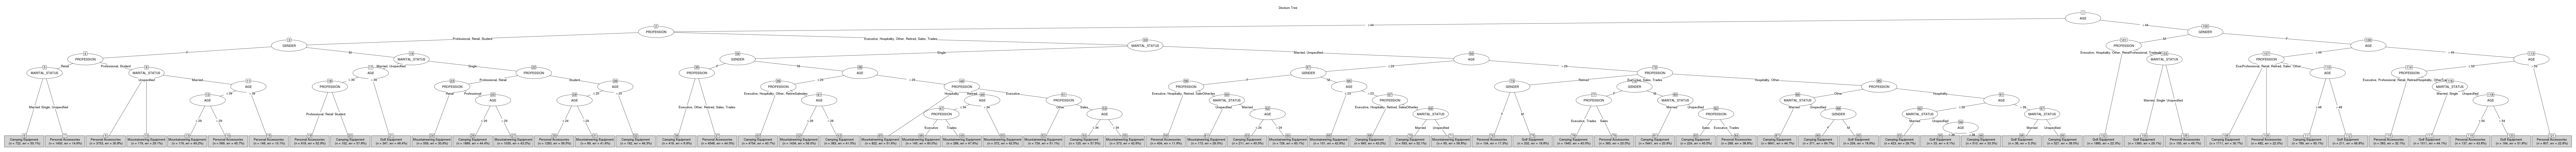

In [16]:
library(repr)

# Change plot size to 136 x 8
options(repr.plot.width=136, repr.plot.height=8)

plot(classifierModel, type="simple",main="Decison Tree", drop_terminal = TRUE)